<a href="https://colab.research.google.com/github/danmenloz/LeafWilting/blob/main/DanielCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd
import cv2
from PIL import Image
import os
 
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
def loadImages(path):
    # list with paths of all images in the folder
    f_paths = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    # list with file names of the images
    f_names = [ os.path.basename(i) for i in f_paths ]
    # list with images
    # images = [ cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in files_path ] # cv read takes too long!
    images = [ plt.imread(i) for i in f_paths ]

    return f_names, images


def loadAnnotations(path):
  table = pd.read_csv(path)
  # file_names = list(table[['file_name']])
  f_names = [x[0] for x in table.values] #read colum 0
  annotations = np.asarray(table[['annotation']]).ravel()
  return f_names, annotations
 

def buildDataset(f_names, annotations, img_names, images):
  img_set = [] # empty list
  for i in range(len(f_names)):
    img_dict = {} # empty dictionary
    try:
      # find image name in annotation file
      idx = f_names.index(img_names[i])
      # create dictionary and add it to the list
      img_dict['file_name'] = f_names[i]
      img_dict['annotation'] = annotations[i]
      img_dict['image'] = images[i]
      img_set.append(img_dict)
    except:
      print("Image " + img_names[i] + " not found in annotations file!")
  
  return img_set


def reduce_image(images, imgNewSz):
  #Reduce the images by pixel size
  reduced_images = []
  for i in images:
    rimg = cv2.resize(i, (imgNewSz,imgNewSz), interpolation = cv2.INTER_AREA)
    # rimg = cv2.resize(i, None, fx=ratio, fy=ratio, interpolation = cv2.INTER_AREA)
    reduced_images.append(rimg)

  reduced_images = np.array(reduced_images)
  return reduced_images


# Histogram equalization
# https://stackoverflow.com/questions/31998428/opencv-python-equalizehist-colored-image
def histEqualization(dataset):
  equ_dataset = dataset # copy input dataset
  for n in range(len(dataset)):
    # convert to YUV
    img_yuv = cv2.cvtColor(dataset[n]['image'], cv2.COLOR_BGR2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    # convert the YUV image back to RGB format
    equ_dataset[n]['image']  = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return equ_dataset


def countClasses(dataset):
  labels = np.asarray( [d['annotation'] for d in dataset] )
  print("Class 0:", np.sum(labels == 0))
  print("Class 1:", np.sum(labels == 1))
  print("Class 2:", np.sum(labels == 2))
  print("Class 3:", np.sum(labels == 3))
  print("Class 4:", np.sum(labels == 4))
  print(" Total :", len(labels))
  print("/n")

In [ ]:
#Access data in Google Drive
from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Retrieve original images
data_path = "drive/My Drive/ECE_542-Project_1/TrainingData"
# images, annotations = get_data(path)
img_names, images = loadImages(data_path)

# Get annotation csv file
# annotations = pd.read_csv(data_path)
annotations_path = os.path.join(data_path, 'Annotations.csv')
f_names, labels = loadAnnotations(annotations_path)

# Build dictionary with data
dataset = buildDataset(f_names, labels, img_names, images)
print("Initial count")
countClasses(dataset)

# Preprocess images using histogram equalization
# dataset = histEqualization(dataset)


Initial count
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275
/n


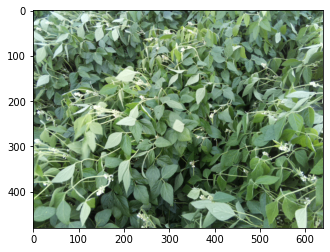

In [ ]:
#Display an image from dataset
sampleID = 19
plt.imshow(dataset[sampleID]['image'])
# print(dataset[sampleID])

In [ ]:
# Labels
# labels = np.asarray(annotations[['annotation']]).ravel() # Labels

# Spliting in images and pre_test
# split = int(0.8 * len(images))
# pre_test = images[split:]
# images = images[:split]
# pre_test_labels = labels[split:]
# labels = labels[:split]
print("Before Split")
countClasses(dataset)

# Extract the same number of samples for the test dataset
n_samples = 20;
test_dataset = [] # start with empty set
for a in range(5):
  cnt = 0
  for i in dataset:
    if i['annotation']==a and cnt<n_samples:
      test_dataset.append(i)
      cnt += 1
# Update dataset
dataset = [i for i in dataset if i not in test_dataset]

print("After Split")
countClasses(dataset)


Before Split
Class 0: 488
Class 1: 329
Class 2: 130
Class 3: 131
Class 4: 197
 Total : 1275
/n
After Split
Class 0: 468
Class 1: 309
Class 2: 110
Class 3: 111
Class 4: 177
 Total : 1175
/n


In [ ]:
# Data Augmentation Schemes
 
# Flipping image
def flip_image(images, labels, size = 480, flips = 3):
  images = reduce_image(images, size)
  flip_h = np.flip(images, axis = 1)
  flip_v = np.flip(images, axis = 2)
  flip_hv = np.flip(np.flip(images, axis = 1), axis = 2)
  if flips == 1:
     flip = np.vstack([images, flip_h])
     labels = np.asarray(list(labels) * 2).ravel()
  if flips == 2:
    flip = np.vstack([images, flip_h, flip_v])
    labels = np.asarray(list(labels) * 3).ravel()
  if flips == 3:
    flip = np.vstack([images, flip_h, flip_v, flip_hv])
    labels = np.asarray(list(labels) * 4).ravel()
  return flip, labels

# Gamma correction
def gamma_image(images, labels, gamma_values):
  images_gamma = [images]
  for gamma in gamma_values:
    #gamma_M = (np.power(images/255.0, 1/gamma) * 255).astype(int)
    images_gamma.append((np.power(images/255.0, 1/gamma) * 255).astype(int))#[labels == where_labels])
  images_gamma = np.vstack(images_gamma)
  #images_gamma = np.asarray(images_gamma)
  labels = np.asarray(list(labels) * (len(gamma_values) + 1)).ravel()
  return images_gamma, labels

# Divide image (NO IMPROVEMENT)
def slice_image(images, labels, num_slices):
  images_slice = []
  num_slices = 5
  sx = (np.arange(0, num_slices + 1) / num_slices * images.shape[1]).astype(int)
  sy = (np.arange(0, num_slices + 1) / num_slices * images.shape[2]).astype(int)
  for j in range(num_slices):
    for i in range(num_slices):
      images_slice.append(images[:, sx[i]:sx[i + 1], sy[j]:sy[j + 1], :])
  images_slice = np.vstack(images_slice)
  labels = np.asarray(list(labels) * num_slices * num_slices).ravel()
  return images_slice, labels



In [ ]:
# Data augmentation
# Flipping image
# def flip_image(images, labels):
#   idx = np.asarray([2, 3, 4])
#   n = 0
#   row_idx = []
#   for label in labels:
#     if any(i == label for i in idx):
#       row_idx.append(n)
#       n +=1
#     else:
#       n +=1 

#   row_idx = np.asarray(row_idx)
#   flip_h = np.flip(images[row_idx], axis = 1)
#   flip = np.vstack([images, flip_h])
#   hold = labels[row_idx]
#   labels = np.hstack([labels, hold])
#   return flip, labels

# images, labels = flip_image(images, labels)
# print(images.shape)
# print(labels.shape)
# print("Class 0:", np.sum(labels == 0))
# print("Class 1:", np.sum(labels == 1))
# print("Class 2:", np.sum(labels == 2))
# print("Class 3:", np.sum(labels == 3))
# print("Class 4:", np.sum(labels == 4))


# Data Augmentation Schemes
datagen = ImageDataGenerator(
	rotation_range=10,
	# zoom_range=0.15, # [1-zoom_range,1+zoom_range]
	# width_shift_range=0.2,
	# height_shift_range=0.2,
	# shear_range=0.15,
  # brightness_range=[0.4,1.5],
	horizontal_flip=True,
	fill_mode="reflect") #  nearest

# Resize images
size = 112
images = np.array( [ d['image'] for d in dataset ] ) # extract images from dataset
images  = reduce_image(images, size)

# Replace images in the dataset
for d in range(len(dataset)):
  dataset[d]['image'] = images[d]

# Batch size to generate images
b_size = 32
# Total images per class
img_total = 1000

# Emtpy lists
images = []
labels = []

for c in range(5): # 5 classes
  # Extract images and labels from the clases
  imgs = np.array( [ d['image'] for d in dataset if d['annotation']==c ] )
  lbls = np.array( [ d['annotation'] for d in dataset if d['annotation']==c ] )

  batches = 0
  for gen_imgs, gen_lbls in datagen.flow(imgs, lbls,  batch_size=b_size):
    # add data to the lists
    images.extend(gen_imgs) 
    labels.extend(gen_lbls)
    print("C=", c)
    print(len(images))
    print(len(labels))
    batches += 1
    if len(images) >= img_total*(c+1):  #int(img_total/b_size):  # 10 batches
      # we need to break the loop by hand because
      # the generator loops indefinitely
      break


C= 0
32
32
C= 0
64
64
C= 0
96
96
C= 0
128
128
C= 0
160
160
C= 0
192
192
C= 0
224
224
C= 0
256
256
C= 0
288
288
C= 0
320
320
C= 0
352
352
C= 0
384
384
C= 0
416
416
C= 0
448
448
C= 0
468
468
C= 0
500
500
C= 0
532
532
C= 0
564
564
C= 0
596
596
C= 0
628
628
C= 0
660
660
C= 0
692
692
C= 0
724
724
C= 0
756
756
C= 0
788
788
C= 0
820
820
C= 0
852
852
C= 0
884
884
C= 0
916
916
C= 0
936
936
C= 0
968
968
C= 0
1000
1000
C= 1
1032
1032
C= 1
1064
1064
C= 1
1096
1096
C= 1
1128
1128
C= 1
1160
1160
C= 1
1192
1192
C= 1
1224
1224
C= 1
1256
1256
C= 1
1288
1288
C= 1
1309
1309
C= 1
1341
1341
C= 1
1373
1373
C= 1
1405
1405
C= 1
1437
1437
C= 1
1469
1469
C= 1
1501
1501
C= 1
1533
1533
C= 1
1565
1565
C= 1
1597
1597
C= 1
1618
1618
C= 1
1650
1650
C= 1
1682
1682
C= 1
1714
1714
C= 1
1746
1746
C= 1
1778
1778
C= 1
1810
1810
C= 1
1842
1842
C= 1
1874
1874
C= 1
1906
1906
C= 1
1927
1927
C= 1
1959
1959
C= 1
1991
1991
C= 1
2023
2023
C= 2
2055
2055
C= 2
2087
2087
C= 2
2119
2119
C= 2
2133
2133
C= 2
2165
2165
C= 2
2197
2197
C= 

In [ ]:
# Check agumented data

# Convert to uint8
images = [ img.astype('uint8') for img in images ]

# convert to np arrays
images = np.asarray(images)
labels = np.asarray(labels)

print(images.shape)
print(labels.shape)
print("Class 0:", np.sum(labels == 0))
print("Class 1:", np.sum(labels == 1))
print("Class 2:", np.sum(labels == 2))
print("Class 3:", np.sum(labels == 3))
print("Class 4:", np.sum(labels == 4))



(5025, 112, 112, 3)
(5025,)
Class 0: 1000
Class 1: 1023
Class 2: 990
Class 3: 999
Class 4: 1013


In [ ]:
print(labels)

[0 0 0 ... 4 4 4]


In [ ]:
# Randomnize dataset
dataset_list = list(zip(images, labels))
np.random.shuffle(dataset_list)
images, labels = zip(*dataset_list)
images = np.asarray(images)
labels = np.asarray(labels)
print(labels)

[3 4 4 ... 0 1 3]


In [ ]:
# Reducing Images
# size = 224
# resized_images = reduce_image(images, size)
# resized_images = images # no resizing for now
# resized_images = images
# print(resized_images.shape)
# print(pre_test.shape)

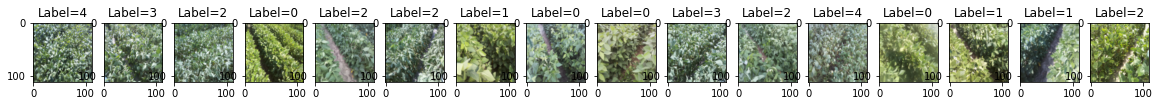

In [ ]:
# Plotting 16 random images
Num = 16
N = np.random.randint(0,len(images), Num) 
# Plot
fig, axes = plt.subplots(1, Num, figsize=(20,3))
ax = axes.ravel()
for i in range(Num):
  ax[i].imshow(images[N[i]])
  title = "Label=" + str(labels[N[i]])
  ax[i].title.set_text(title)

In [ ]:

#Keeping 40% for Validation
valid_set_pc = 0.4
split= int((len(images))*(1-valid_set_pc))

#labels = annotations[['annotation']]
validX = images[split:]
validY = labels[split:]
 
trainX = images[:split]
trainY = labels[:split]

#Convert from integers to floats
images = images.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
 
# Normalize to range 0-1
images = images / 255.0
trainX = trainX / 255.0
validX = validX / 255.0
 
print(np.unique(labels), np.unique(trainY), np.unique(validY))
 
# One-hot encoding of outputs
labels = to_categorical(labels)
trainY = to_categorical(trainY)
validY = to_categorical(validY)
 
print(images.shape)
print(labels.shape)

[0 1 2 3 4] [0 1 2 3 4] [0 1 2 3 4]
(5025, 112, 112, 3)
(5025, 5)


In [ ]:
# #create image data augmentation generator
# datagen = ImageDataGenerator(zoom_range=0.1, horizontal_flip=True,
#                              rescale=1./255, rotation_range=45, fill_mode='nearest')
# #prepare iterator
# it = datagen.flow(images, labels, batch_size = 32)

# #BUILD MODEL
# #...........

# #train network
# H =model.fit(it, epochs=35, validation_data=(validX, validY), verbose=1, steps_per_epoch=len(images)//32) #32=batch size

print(trainX.shape)
print(trainY.shape)

print(validX.shape)
print(validY.shape)

(3015, 112, 112, 3)
(3015, 5)
(2010, 112, 112, 3)
(2010, 5)


In [ ]:
# # Defining Base CNN Model
# def define_base_model(height, width, rate):
#     model = Sequential()
 
#     model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(height, width, 3)))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
#     model.add(Dropout(rate))
#     model.add(MaxPooling2D((2, 2)))
 
#     #model.add(Conv2D(128, (3, 3), activation='relu',  padding='same'))
#     #model.add(Dropout(rate))
#     #model.add(MaxPooling2D((2, 2)))
 
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(rate))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(rate))    
#     model.add(Dense(5, activation='softmax'))
 
#     return model


In [ ]:
# Transfer learning

# loading the vgg16 model
from keras.applications.vgg16 import VGG16

# load model and specify a new input shape for images
vgg = VGG16(input_shape=(size, size, 3), include_top=False)

# Freeze model
vgg.trainable = False


x = Flatten()(vgg.output)
prediction = Dense(5, activation='softmax')(x) # 5 classes

# Creating instance
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(),
                    metrics=['categorical_accuracy'])


# summarize the model
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)      

In [ ]:
# Train the model
history = model.fit(trainX, trainY, epochs=35, validation_data=(validX, validY), verbose=1)

Epoch 1/35
95/95 [==============================] - 7s 70ms/step - loss: 1.2612 - categorical_accuracy: 0.4693 - val_loss: 1.0567 - val_categorical_accuracy: 0.5766
Epoch 2/35
95/95 [==============================] - 6s 64ms/step - loss: 0.9645 - categorical_accuracy: 0.6149 - val_loss: 0.9616 - val_categorical_accuracy: 0.5945
Epoch 3/35
95/95 [==============================] - 6s 66ms/step - loss: 0.8380 - categorical_accuracy: 0.6760 - val_loss: 0.8582 - val_categorical_accuracy: 0.6677
Epoch 4/35
95/95 [==============================] - 6s 67ms/step - loss: 0.7556 - categorical_accuracy: 0.7231 - val_loss: 0.8195 - val_categorical_accuracy: 0.6706
Epoch 5/35
95/95 [==============================] - 6s 67ms/step - loss: 0.6994 - categorical_accuracy: 0.7453 - val_loss: 0.8264 - val_categorical_accuracy: 0.6418
Epoch 6/35
95/95 [==============================] - 6s 67ms/step - loss: 0.6415 - categorical_accuracy: 0.7784 - val_loss: 0.7508 - val_categorical_accuracy: 0.7015
Epoch 7/35

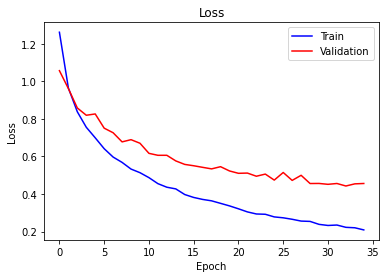

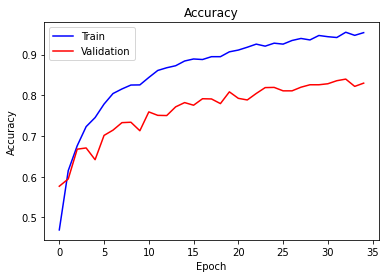

In [ ]:
def plot_history(history):
      # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
 
# Plotting results of training
plot_history(history)

In [ ]:
# Fine tunning

# Freeze model
# vgg.trainable = True
# model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=[keras.metrics.BinaryAccuracy()])

# model.compile(loss='categorical_crossentropy',
#                     optimizer=Adam(learning_rate=0.00001),
#                     metrics=['categorical_accuracy'])

# history1 = model.fit(trainX, trainY, epochs=5, validation_data=(validX, validY), verbose=1)
# plot_history(history1)

In [ ]:
# F1 Score
trueY = np.argmax(validY, axis=1)

# base_results = model.predict_classes(validX) # 'Functional' object has no attribute 'predict_classes'
base_results = model.predict(validX)
base_results = np.argmax(base_results,axis=1)

base_f1_score = f1_score(trueY, base_results, average=None)
print(base_f1_score)

[0.8354143  0.59780908 0.88423645 0.94255875 0.84381779]


In [ ]:
# Test set

# extract images and labels from dataset
pre_test_images = [ d['image'] for d in test_dataset ]
pre_test_labels = [ d['annotation'] for d in test_dataset ]

# Measure performance on test set
pre_test_images = reduce_image(pre_test_images, size)
pre_test_results = model.predict(pre_test_images)
pre_test_results = np.argmax(pre_test_results,axis=1)

print(np.sum(pre_test_results == pre_test_labels)/len(pre_test_labels))

0.2


In [ ]:
# F1 Score Test set
trueY = pre_test_labels
test_f1_score = f1_score(trueY, pre_test_results, average=None)
print(test_f1_score)

[0.35416667 0.         0.15384615 0.         0.        ]


In [ ]:
# Generate CSV
test_path = "/content/drive/My Drive/ECE_542-Project_1/TestData-20201017T151905Z-001.zip"
 
zip1 = zipfile.ZipFile(test_path)
listOfFileNames1 = sorted(zip1.namelist())

# Remove 'Directory name'
file_name = []
for f in listOfFileNames1:
  file_name.append(f.replace('TestData/',''))

print(file_name)
 
#Create array of test data
test = []
for file in listOfFileNames1:
  if file.endswith('.jpg'):
    img1 = plt.imread(zip1.open(file))
    test.append(img1)
  
test = np.array(test)

test_images = reduce_image(test, size)
# print(test_images.shape)
test_results = model.predict(test_images)
test_results = np.argmax(test_results,axis=1)

print("Class 0:", np.sum(test_results == 0))
print("Class 1:", np.sum(test_results == 1))
print("Class 2:", np.sum(test_results == 2))
print("Class 3:", np.sum(test_results == 3))
print("Class 4:", np.sum(test_results == 4))

# Generate CSV file
data = {'file_name': file_name,'annotation': test_results  }
export_data = pd.DataFrame(data, columns=['file_name', 'annotation'])
export_data.to_csv (r'/content/drive/My Drive/ECE_542-Project_1/prediction.csv', index = False, header=True)
print(export_data)

['020031.jpg', '020244.jpg', '020446.jpg', '020597.jpg', '020693.jpg', '020720.jpg', '020783.jpg', '020795.jpg', '020810.jpg', '020833.jpg', '020835.jpg', '020848.jpg', '020861.jpg', '020877.jpg', '020881.jpg', '020963.jpg', '020980.jpg', '021039.jpg', '021048.jpg', '021095.jpg', '021104.jpg', '021220.jpg', '021267.jpg', '021366.jpg', '021423.jpg', '021455.jpg', '021457.jpg', '021621.jpg', '021659.jpg', '021729.jpg', '021763.jpg', '021773.jpg', '021818.jpg', '021819.jpg', '022010.jpg', '022021.jpg', '022090.jpg', '022127.jpg', '022145.jpg', '022158.jpg', '022202.jpg', '022231.jpg', '022377.jpg', '022385.jpg', '022432.jpg', '022438.jpg', '022497.jpg', '022551.jpg', '022554.jpg', '022628.jpg', '022629.jpg', '022642.jpg', '022757.jpg', '022800.jpg', '022826.jpg', '023041.jpg', '023112.jpg', '023195.jpg', '023229.jpg', '023278.jpg', '023291.jpg', '023304.jpg', '023330.jpg', '023369.jpg', '023370.jpg', '023381.jpg', '023458.jpg', '023468.jpg', '023474.jpg', '023476.jpg', '023508.jpg', '0235